<a href="https://colab.research.google.com/github/scalabrinig/cdProjetoAplicadoIV/blob/master/projeto/cd_projeto_aplicado_IV_entrega_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/joaonetto/projetoAplicado-IV/refs/heads/main/Images/Mackenzie.png" width="25%" align="left"/>

# **PROJETO APLICADO IV - Ciência de Dados EaD - 2026/01**


# **Entrega 3**

---

# **Titulo do Projeto**:

### *ChronoSec*: Detecção Comportamental e Séries Temporais para Segurança de Login (UEBA) em Eventos Google
---

In [ ]:
#@title **Identificação do Grupo e Opção do Projeto**

#@markdown Integrantes do Grupo, nome completo em ordem alfabética (*informe: \<nome\>, \<matrícula\>*)
Aluno1 = 'João Silveira Campos Netto, 10441670' #@param {type:"string"}
Aluno2 = 'Alex Luiz Rabelo, 10442968' #@param {type:"string"}
Aluno3 = 'Antônio Henrique Caldas Mello, 10433799' #@param {type:"string"}

# Introdução

Em ambientes corporativos, o processo de autenticação é um dos pontos mais visados por atacantes porque concentra alto valor: uma credencial válida pode abrir portas para e-mail, arquivos, aplicações internas e serviços críticos. Na prática, a maior parte dos incidentes que começam por identidade deixa rastros no tempo: sequências de tentativas de login, falhas repetidas, alternância de métodos e “rajadas” de eventos em poucos minutos. Esse comportamento temporal aparece tanto em ataques automatizados (**brute force**, **password spraying**, **credential stuffing**) quanto em atividades suspeitas pós-comprometimento (**uso indevido de tokens**, **reautenticações frequentes**, **tentativas de contornar MFA**). Por isso, analisar a dimensão de **velocidade e frequência** dos logins é uma forma direta e eficaz de aumentar a capacidade de detecção com base em evidências observáveis.

O principal motivador para o uso de **Velocity Checks** é que comportamentos maliciosos tendem a violar padrões naturais de uso. Usuários legítimos normalmente apresentam cadências previsíveis: p**oucas tentativas em curtos intervalos**, **falhas ocasionais** e **distribuição de horários relativamente consistente**. Já ataques e automações elevam abruptamente a taxa de eventos — por exemplo, muitas tentativas em 5 ou 15 minutos, altas taxas de falha no mesmo período, ou intervalos de segundos entre requisições. Ao modelar esse **“ritmo”** e compará-lo com um baseline, conseguimos reduzir o tempo de detecção e priorizar investigações, mesmo quando o atacante usa IPs variados, proxies ou distribui tentativas em diferentes endpoints.

O objetivo geral do **Velocity Checks**, neste projeto, é transformar logs de autenticação em **sinais temporais quantificáveis** que permitam identificar picos anômalos de atividade e padrões de falha compatíveis com abuso de credenciais. Para isso, calculamos contagens em janelas deslizantes (ex.: 5 minutos, 15 minutos, 1 hora) e métricas derivadas (como proporção de falhas e tempo desde o evento anterior), estabelecemos limiares adaptativos por usuário e/ou por domínio (por exemplo, percentis altos como p99) e consolidamos esses sinais em um score explicável (0–100) com justificativas claras (“burst 5m”, “alta falha 15m”, “delta muito baixo”). O resultado esperado é um mecanismo reprodutível de detecção e priorização, capaz de destacar casos relevantes para análise de segurança e servir de base para etapas mais avançadas do projeto, como **Impossible Travel** e modelagens **probabilísticas/sequenciais**.

# Referencial Teórico

# Diagrama de Solução

<img src="https://github.com/joaonetto/projetoAplicado-IV/blob/main/Images/VelocityCheck.jpg?raw=true" width="100%"/>

A figura apresentada ilustra um cenário no qual um agente malicioso (atacante) pode empregar diferentes estratégias para obter acesso não autorizado a uma infraestrutura em nuvem. Na ausência de controles adicionais e *guardrails*, como mecanismos de limitação de tentativas, políticas adaptativas de autenticação e validações contextuais, o atacante tende a recorrer a técnicas amplamente conhecidas, como **brute force**, **password spraying** e **credential stuffing**.

Durante a fase de tentativa de acesso, seja por meio de ações manuais ou de automação, os sistemas de autenticação registram cada requisição e seu respectivo desfecho, gerando logs detalhados (por exemplo, sucesso, falha, tipo de fator de autenticação, dispositivo e outros atributos). Para este projeto, o foco central consiste em analisar e caracterizar o comportamento inicial dessas tentativas, especialmente quando se observa a ocorrência de múltiplas requisições concentradas em um mesmo usuário e em um curto intervalo de tempo. Esse padrão, por divergir do comportamento esperado, é tratado como indício de anomalia e pode ser utilizado como base para detecção.

Sob a perspectiva de engenharia de dados, considera-se um pipeline cuja ingestão parte de logs de autenticação, os quais são, por natureza, eventos em streaming (registros discretos emitidos continuamente). Esses eventos devem ser avaliados por meio de janelas deslizantes de tempo (**sliding windows**), que permitem computar métricas agregadas em intervalos móveis, por exemplo, 5 minutos, 15 minutos ou 1 hora e analisando, em paralelo, o comportamento recente do usuário e/ou do domínio. A adoção de janelas deslizantes é relevante tanto para a análise operacional (observação de padrões em tempo próximo do real) quanto para o aprendizado contínuo do ambiente, uma vez que os parâmetros de detecção podem ser recalibrados de forma progressiva, tornando-se mais ou menos restritivos conforme o perfil observado.

As agregações produzidas pelas janelas temporais geram indicadores derivados, tais como contadores de falhas, taxas de tentativa por unidade de tempo, variações em relação ao padrão usual e métricas de **burst** (rajadas), que capturam concentrações anormais de eventos em curtos períodos. Entretanto, a simples identificação de picos não é suficiente: torna-se necessário estabelecer uma linha de base (**baseline**) que represente o **“normal”** para cada contexto. Essa normalidade tende a variar significativamente entre usuários, aplicações e domínios organizacionais. Nesse sentido, a adoção de limiares baseados em percentis (por exemplo, o percentil 99) contribui para reduzir falsos positivos em nível individual e, simultaneamente, preservar a sensibilidade para capturar eventos extremos, incluindo picos potencialmente coletivos no nível do domínio (organização).

No nível do usuário, um **burst** observado em janela deslizante pode indicar tentativas consecutivas e automatizadas, elevando a probabilidade de um ataque do tipo **brute force**. Em contraste, no nível do domínio, ao considerar a soma e a distribuição das tentativas entre múltiplos usuários, torna-se possível identificar padrões compatíveis com **password spraying**, em que o atacante testa uma mesma senha (ou um pequeno conjunto de senhas) contra vários usuários, caracterizando o domínio como alvo preferencial da campanha.

Após a aplicação das métricas e dos limiares (para usuário e/ou domínio), o evento pode ser representado por um **score de risco**, permitindo classificação e priorização. No contexto desta proposta, o **score** pode ser estruturado pelos seguintes componentes:

1.	**Severidade**: magnitude do excesso em relação ao baseline estabelecido;
2.	**Soma ponderada (score_raw)**: combinação de métricas com pesos definidos (por exemplo, falhas, burst, entre outros);
3.	**Normalização do score**: transformação do valor para uma escala interpretável (por exemplo, 0 a 100);
4.	**Reason**: justificativa textual e rastreável do **score** (explicabilidade baseada nas evidências observadas).

Por fim, os resultados inferidos ao longo das janelas temporais habilitam ações responsivas (manuais ou automatizadas), alinhadas ao risco estimado. Exemplos de medidas incluem:

- redefinição de senha;
- bloqueio temporário do usuário;
- solicitação de MFA;
- contato preventivo com o usuário;
- ações proporcionais ao contexto e à política de segurança vigente.

Dessa forma, o pipeline não apenas detecta sinais iniciais de abuso, como também sustenta decisões operacionais com base em evidências, reduzindo o tempo de resposta e ampliando a resiliência do ambiente de autenticação.

# EDA e Pré-processamento dos dados

Conforme apresentado anteriormente, as etapas que antecedem as análises propriamente ditas foram implementadas e documentadas na página principal deste projeto, bem como em seções específicas do repositório. Nessas partes, são descritos os procedimentos de preparação e qualificação dos dados, com ênfase em:

- **Pseudonimização dos dados**: técnica aplicada para reduzir a identificabilidade de entidades, preservando utilidade analítica. Disponível em: [Pseudonymize](https://github.com/joaonetto/projetoAplicado-IV/blob/main/Helpers/01-Pseudonymize/README.md);
- **Enriquecimento por GeoIP**: processo de enriquecimento contextual a partir de informações geográficas derivadas de endereços IP, contribuindo para análises de comportamento e coerência espaço-temporal. Disponível em:  [EnrichData](https://github.com/joaonetto/projetoAplicado-IV/blob/main/Helpers/02-EnrichData/README.md).

Para uma visão completa do contexto, incluindo motivadores, decisões metodológicas e os processos adotados no EDA (Exploratory Data Analysis) e no pré-processamento, recomenda-se a leitura da página principal do projeto: [ChronoSec](https://github.com/joaonetto/projetoAplicado-IV/blob/main/README.md).



# ChronoSec — Velocity Check/Frequency

### Inicialização

In [ ]:
#
# Bibliotecas
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#
# Variáveis
#

# Entrada de Dados
INPUT_CSV = "../projetoAplicado-IV/Data/saida_enriquecida.csv"
SEP = ","

# Saídas
FEAT_OUT = "outputs_A_velocity_features.csv"
USER_OUT = "outputs_A_velocity_user_summary.csv"
BURST_OUT = "outputs_A_velocity_bursts.csv"
SCORED_OUT = "outputs_A_velocity_scored.csv"

# Limitadores
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)


### Encontrar contadores de eventos de login em uma janela de tempo

Manter colunas preferenciais:
- Data;
- Timestemp (new);
- Usuário;
- Domínio;
- Evento;
- is_login_like (new);
- is_failure (new).

Para **is_login_like** temos:
$$\text{cnt}_{w}(t,u)= \sum_{i: t-w < t_i \le t} \mathbb{1}(\text{login-like}_i \land \text{usuário}_i=u)$$

Sendo:

- $\text{cnt}_{w}(t,u)$ Como contador de eventos de login (login-like) do usuário $u$ em uma janela de tempo de tamanho $w$, calculada no instante $t$. Exemplo: $\text{cnt}_{5min}(t,u)$.
- $$\sum_{i: t-w < t_i \le t}$$ traduz em janela temporal dos eventos $i$ com os timestemps $t_{i}$ em uma janela. Sendo $t$ o agora, ou seja, o atual e $w$ a duração da janela.
- O $\mathbb{1}(\text{login-like})$ representa um booleano, sendo *True* se verdadeiro evento "login success" e outros e *False* para *logout*.
- $\land \text{usuário}_i=u$, onde o evento $i$ pertence ao usuário $u$.

Para **is_failure** temos:

$$\text{fail}_{w}(t,u)= \sum_{i: t-w < t_i \le t} \mathbb{1}(\text{falha}_i \land \text{usuário}_i=u)$$

Segue o mesmo conceito que **is_login_like** mas para processos de falha, portanto detecta a quantidade de erros de autenticação de um determinado usuário $u$ ao longo do tempo $w$ de um evento $i$.


In [ ]:
df = pd.read_csv(INPUT_CSV, sep=SEP, dtype=str)

# Timestamp em UTC (facilita rolling em janelas)
df['ts'] = pd.to_datetime(df['Data'], errors='coerce', utc=True)
df = df.dropna(subset=['ts']).copy()

# Normalização do evento
df['evento_norm'] = df['Evento'].astype(str).str.strip().str.lower()

# Eventos 'login-like' (ajuste se quiser restringir)
login_like = {
    'login_success', 'login_failure', 'login_challenge', 'login_verification',
    'login', 'signin', 'sign_in', 'reauth'
}
df['is_login_like'] = df['evento_norm'].isin(login_like)
df['is_failure'] = df['evento_norm'].eq('login_failure')

# Ordenação é essencial para análise temporal
df = df.sort_values(['Usuário','ts'], kind='mergesort').reset_index(drop=True)

df[['Data','ts','Usuário','Domínio','Evento','is_login_like','is_failure']].head()

,Data,ts,Usuário,Domínio,Evento,is_login_like,is_failure
0,2025-03-09T07:25:17-0300,2025-03-09 10:25:17+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,True,False
1,2025-03-17T18:43:32-0300,2025-03-17 21:43:32+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,True,False
2,2025-03-18T15:58:00-0300,2025-03-18 18:58:00+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,logout,False,False
3,2025-03-21T10:24:02-0300,2025-03-21 13:24:02+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,True,False
4,2025-03-21T10:45:28-0300,2025-03-21 13:45:28+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,logout,False,False


###  Feature Engineering (rolling por usuário)

Adicionado (por usuário):
- `cnt_5m`, `cnt_15m`, `cnt_1h`, `cnt_24h` (contagem de eventos login-like)
- `fail_15m`, `fail_1h` e `fail_ratio_15m`, `fail_ratio_1h`
- `delta_prev_s` (tempo desde evento anterior)


In [ ]:
# Garantir ordenação
df = df.sort_values(["Usuário", "ts"], kind="mergesort").reset_index(drop=True)

# Criar id único por linha para colar features sem erro
df["_row_id"] = np.arange(len(df))

# Separar linhas válidas (Usuário não nulo) — groupby ignora NaN
valid = df[df["Usuário"].notna()].copy()

# Trabalhar com ts como índice para rolling temporal
feat = valid.set_index("ts").copy()

# Rolling counts (login-like) — atribuição por posição (evita reindex com ts duplicado)
feat["cnt_5m"]  = feat.groupby("Usuário", sort=False)["is_login_like"].rolling("5min").sum().to_numpy()
feat["cnt_15m"] = feat.groupby("Usuário", sort=False)["is_login_like"].rolling("15min").sum().to_numpy()
feat["cnt_1h"]  = feat.groupby("Usuário", sort=False)["is_login_like"].rolling("60min").sum().to_numpy()
feat["cnt_24h"] = feat.groupby("Usuário", sort=False)["is_login_like"].rolling("24h").sum().to_numpy()

# Rolling failures
feat["fail_15m"] = feat.groupby("Usuário", sort=False)["is_failure"].rolling("15min").sum().to_numpy()
feat["fail_1h"]  = feat.groupby("Usuário", sort=False)["is_failure"].rolling("60min").sum().to_numpy()

# Ratios (evita divisão por zero)
feat["fail_ratio_15m"] = feat["fail_15m"] / feat["cnt_15m"].replace(0, np.nan)
feat["fail_ratio_1h"]  = feat["fail_1h"]  / feat["cnt_1h"].replace(0, np.nan)

# Delta desde evento anterior (por usuário) — por posição
feat["delta_prev_s"] = (
    feat.groupby("Usuário", sort=False)
        .apply(lambda g: g.index.to_series().diff().dt.total_seconds())
        .to_numpy()
)

# Voltar ts para coluna
feat = feat.reset_index()

# Selecionar apenas colunas de features + _row_id para merge
feat_small = feat[[
    "_row_id",
    "cnt_5m", "cnt_15m", "cnt_1h", "cnt_24h",
    "fail_15m", "fail_1h",
    "fail_ratio_15m", "fail_ratio_1h",
    "delta_prev_s"
]].copy()

# Merge de volta no df completo — mantém as linhas com Usuário NaN (features ficam NaN)
feat = df.merge(feat_small, on="_row_id", how="left").drop(columns=["_row_id"])

print("Usuário em feat.columns?", "Usuário" in feat.columns)
feat[["Data","ts","Usuário","Domínio","Evento","cnt_5m","cnt_15m","fail_ratio_15m","delta_prev_s"]].head()


Usuário em feat.columns? True


,Data,ts,Usuário,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s
0,2025-03-09T07:25:17-0300,2025-03-09 10:25:17+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,NaN
1,2025-03-17T18:43:32-0300,2025-03-17 21:43:32+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,731895.0
2,2025-03-18T15:58:00-0300,2025-03-18 18:58:00+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,logout,0.0,0.0,NaN,76468.0
3,2025-03-21T10:24:02-0300,2025-03-21 13:24:02+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,239162.0
4,2025-03-21T10:45:28-0300,2025-03-21 13:45:28+00:00,USR000069@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,logout,0.0,0.0,NaN,1286.0


### Findings por usuário

Leva em consideração o baseline e picos de autenticação, incluindo a máxima para cada contador por usuário e total de eventos encontrados.

In [ ]:
user_summary = feat.groupby('Usuário').agg(
    total_events=('Evento', 'count'),
    total_login_like=('is_login_like', 'sum'),
    max_cnt_5m=('cnt_5m', 'max'),
    max_cnt_15m=('cnt_15m', 'max'),
    max_cnt_1h=('cnt_1h', 'max'),
    max_fail_ratio_15m=('fail_ratio_15m', 'max'),
    max_fail_ratio_1h=('fail_ratio_1h', 'max'),
    min_delta_s=('delta_prev_s', 'min'),
).reset_index()

user_summary.sort_values('max_cnt_5m', ascending=False).head(10)

,Usuário,total_events,total_login_like,max_cnt_5m,max_cnt_15m,max_cnt_1h,max_fail_ratio_15m,max_fail_ratio_1h,min_delta_s
4833,USR938407@acme-d67a0e6c.org.br,219,119,22.0,22.0,22.0,0.0,0.0,0.0
2002,USR373210@acme-d67a0e6c.org.br,445,428,14.0,24.0,76.0,1.0,1.0,0.0
361,USR068210@acme-d67a0e6c.org.br,346,326,12.0,17.0,17.0,0.0,0.0,2.0
750,USR141023@acme-4cdbb9e8.org.br,221,205,11.0,20.0,21.0,1.0,1.0,0.0
772,USR146249@acme-4cdbb9e8.org.br,128,128,11.0,15.0,15.0,1.0,1.0,5.0
3476,USR672113@acme-d67a0e6c.org.br,1245,1179,10.0,14.0,18.0,1.0,1.0,0.0
358,USR067566@acme-4cdbb9e8.org.br,127,117,9.0,9.0,9.0,0.0,0.0,6.0
1619,USR303840@acme-4cdbb9e8.org.br,138,136,9.0,9.0,10.0,1.0,1.0,1.0
2939,USR558171@acme-4cdbb9e8.org.br,43,39,9.0,9.0,9.0,0.0,0.0,1.0
431,USR083800@acme-4cdbb9e8.org.br,150,146,9.0,13.0,30.0,1.0,1.0,4.0


### Candidatos

Busca candidatos *burst* baseado na heurística fixa conforme regra inicial abaixo:
- `cnt_5m >= 10` **OU**
- `cnt_15m >= 5`
- `fail_ratio_15m >= 0.8`

Neste caso traduz que:

- `cnt_5m`: quantos eventos login-like do mesmo usuário ocorreram nos últimos 5 min
- `cnt_15m`: quantos eventos login-like do mesmo usuário ocorreram nos últimos 15 min
- `fail_ratio_15m`: proporção de falhas nos últimos 15 min (falhas / total)
- `delta_prev_s`: segundos desde o evento anterior do mesmo usuário

In [ ]:
burst = feat[
    (feat['cnt_5m'].fillna(0) >= 10) |
    ((feat['cnt_15m'].fillna(0) >= 5) & (feat['fail_ratio_15m'].fillna(0) >= 0.8))
].copy()

burst[['Data','ts','Usuário','Domínio','Evento','cnt_5m','cnt_15m','fail_ratio_15m','delta_prev_s']].head(20)

,Data,ts,Usuário,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s
1275,2025-05-30T08:31:42-0300,2025-05-30 11:31:42+00:00,USR002951@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,4.0,5.0,1.0,116.0
1276,2025-05-30T08:31:55-0300,2025-05-30 11:31:55+00:00,USR002951@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,5.0,6.0,1.0,13.0
1277,2025-05-30T08:38:57-0300,2025-05-30 11:38:57+00:00,USR002951@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,7.0,1.0,422.0
1278,2025-05-30T08:42:02-0300,2025-05-30 11:42:02+00:00,USR002951@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,2.0,6.0,1.0,185.0
1281,2025-05-30T08:51:49-0300,2025-05-30 11:51:49+00:00,USR002951@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,3.0,5.0,1.0,171.0
9559,2025-05-30T09:15:33-0300,2025-05-30 12:15:33+00:00,USR023716@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,3.0,5.0,1.0,18.0
9560,2025-05-30T09:16:00-0300,2025-05-30 12:16:00+00:00,USR023716@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,4.0,6.0,1.0,27.0
9561,2025-05-30T09:16:28-0300,2025-05-30 12:16:28+00:00,USR023716@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,5.0,7.0,1.0,28.0
9562,2025-05-30T09:16:57-0300,2025-05-30 12:16:57+00:00,USR023716@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,6.0,8.0,1.0,29.0
9682,2025-05-30T08:39:16-0300,2025-05-30 11:39:16+00:00,USR024014@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,5.0,5.0,1.0,158.0


### Armazenar para analisar

Grava em arquivo o *dataframe* feat anterior para análise ou reprodução para  outras análises.

Sendo os entregáveis:

- `user_summary.to_csv`: o resumo por usuário com métricas;
- `burst.to_csv`: somente os eventos que passaram na heurística de *burst*;


In [ ]:
feat.to_csv(FEAT_OUT, sep=SEP, index=False)
user_summary.to_csv(USER_OUT, sep=SEP, index=False)
burst.to_csv(BURST_OUT, sep=SEP, index=False)
print('OK:', FEAT_OUT, USER_OUT, BURST_OUT)

OK: outputs_A_velocity_features.csv outputs_A_velocity_user_summary.csv outputs_A_velocity_bursts.csv


### Metricas e eventos possíveis

O histograma apresentado sintetiza a distribuição dos valores observados das métricas calculadas em suas respectivas janelas temporais deslizantes, em particular, *cnt_5m*, *cnt_15m* e *fail_ratio_15m*, para eventos associados a processos do tipo *login-like*. Em termos analíticos, essa visualização permite caracterizar a variabilidade e a frequência relativa desses indicadores ao longo do tempo, oferecendo subsídios para a identificação de padrões usuais de comportamento e de concentrações atípicas (por exemplo, bursts), especialmente relevantes em contextos de detecção de anomalias.



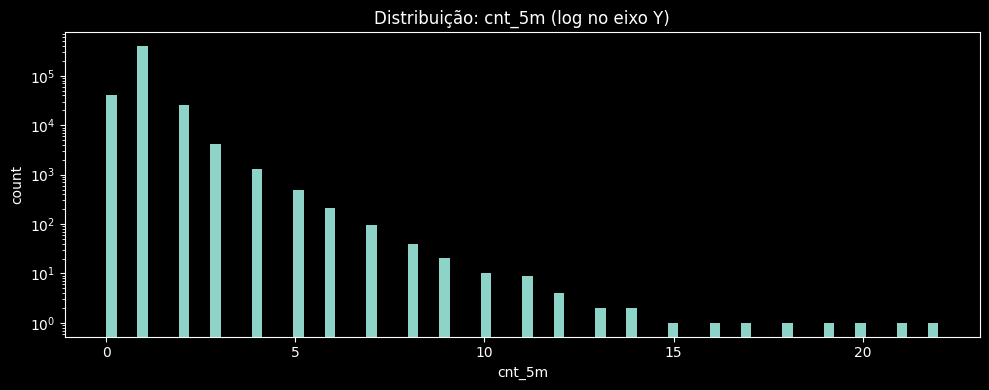

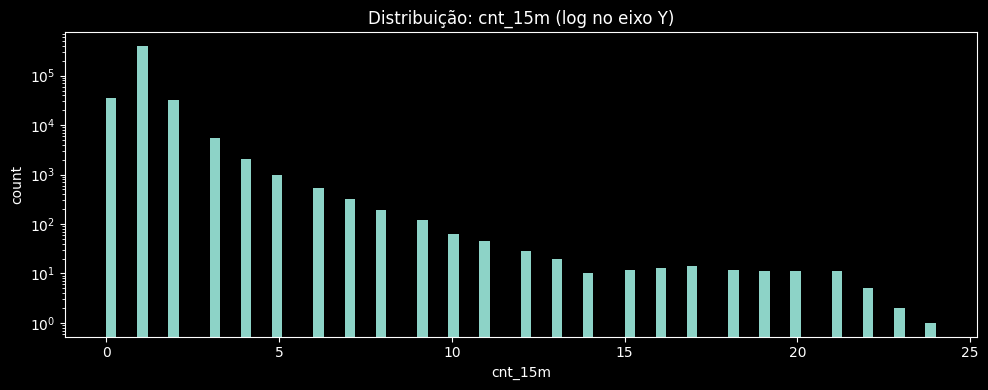

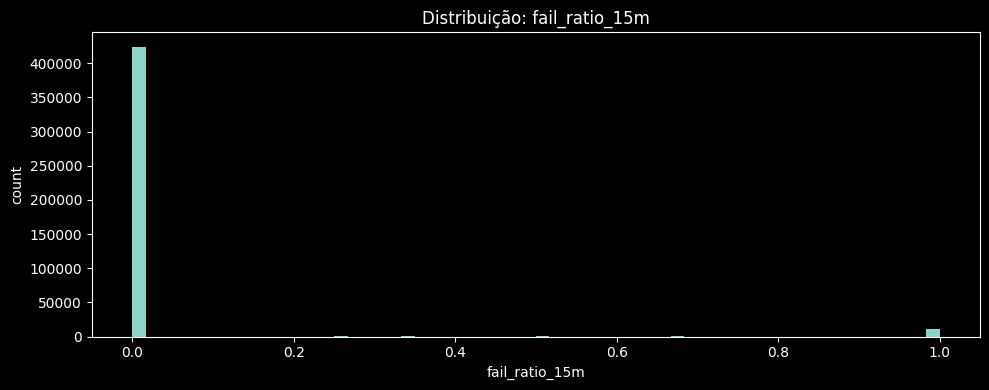

In [ ]:
def plot_hist(series, title, bins=60, logy=False):
    s = pd.to_numeric(series, errors='coerce').dropna()
    plt.figure(figsize=(10,4))
    plt.hist(s, bins=bins)
    if logy:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

plot_hist(feat['cnt_5m'], 'Distribuição: cnt_5m (log no eixo Y)', bins=80, logy=True)
plot_hist(feat['cnt_15m'], 'Distribuição: cnt_15m (log no eixo Y)', bins=80, logy=True)
plot_hist(feat['fail_ratio_15m'], 'Distribuição: fail_ratio_15m', bins=60, logy=False)

## 7) Thresholds por percentil (p99) — por usuário e por domínio

Computamos p99 para `cnt_5m`, `cnt_15m` e `fail_ratio_15m` em dois níveis:
- **Usuário** (baseline individual)
- **Domínio** (baseline organizacional)


In [ ]:
def pctl99(s):
    v = pd.to_numeric(s, errors='coerce').dropna()
    if len(v) == 0:
        return np.nan
    return float(np.nanpercentile(v, 99))

p_user = feat.groupby('Usuário').agg(
    p99_cnt_5m=('cnt_5m', pctl99),
    p99_cnt_15m=('cnt_15m', pctl99),
    p99_fail_ratio_15m=('fail_ratio_15m', pctl99),
).reset_index()

p_dom = feat.groupby('Domínio').agg(
    p99_cnt_5m_dom=('cnt_5m', pctl99),
    p99_cnt_15m_dom=('cnt_15m', pctl99),
    p99_fail_ratio_15m_dom=('fail_ratio_15m', pctl99),
).reset_index()

p_user.head(), p_dom.head()

(                          Usuário  p99_cnt_5m  p99_cnt_15m  p99_fail_ratio_15m
 0  USR000069@acme-4cdbb9e8.org.br         1.0         1.00                0.00
 1  USR000096@acme-4cdbb9e8.org.br         2.0         2.00                0.04
 2  USR000244@acme-043bf1cc.org.br         1.0         1.67                1.00
 3  USR000332@acme-043bf1cc.org.br         1.0         1.00                1.00
 4  USR000434@acme-4cdbb9e8.org.br         2.0         2.00                0.00,
                 Domínio  p99_cnt_5m_dom  p99_cnt_15m_dom  p99_fail_ratio_15m_dom
 0  acme-043bf1cc.org.br            3.00             3.00                    1.00
 1  acme-0a94ff86.org.br            2.00             2.00                    0.54
 2  acme-41f0c89e.org.br            3.00             3.00                    1.00
 3  acme-4cdbb9e8.org.br            3.00             3.00                    1.00
 4  acme-4d49e663.org.br            2.97             2.97                    0.00)

## 8) Score A (0–100) + reasons

Score composto com severidades acima do **p99 do usuário** (pode trocar para domínio, ou combinar).

**score_raw** = 1.0·sev(cnt_5m) + 0.8·sev(cnt_15m) + 1.2·sev(fail_ratio_15m)

Normalização em 0–100 usando quantis globais (p95→0, p99.9→100) e geração de `reasons_A`.


In [ ]:
scored = feat.merge(p_user, on='Usuário', how='left').merge(p_dom, on='Domínio', how='left')

for c in ['cnt_5m','cnt_15m','fail_ratio_15m','p99_cnt_5m','p99_cnt_15m','p99_fail_ratio_15m']:
    scored[c] = pd.to_numeric(scored[c], errors='coerce')

def sev(x, thr):
    if pd.isna(x) or pd.isna(thr) or thr <= 0:
        return 0.0
    return max(0.0, (x - thr) / (thr + 1e-9))

scored['sev_cnt_5m'] = [sev(x,t) for x,t in zip(scored['cnt_5m'], scored['p99_cnt_5m'])]
scored['sev_cnt_15m'] = [sev(x,t) for x,t in zip(scored['cnt_15m'], scored['p99_cnt_15m'])]
scored['sev_fail_ratio_15m'] = [sev(x,t) for x,t in zip(scored['fail_ratio_15m'], scored['p99_fail_ratio_15m'])]

scored['score_raw'] = (
    1.0 * scored['sev_cnt_5m'] +
    0.8 * scored['sev_cnt_15m'] +
    1.2 * scored['sev_fail_ratio_15m']
)

raw = scored['score_raw'].replace([np.inf, -np.inf], np.nan).fillna(0)
p95 = float(np.nanpercentile(raw, 95))
p999 = float(np.nanpercentile(raw, 99.9))
den = max(1e-9, (p999 - p95))
scored['score_A'] = ((raw - p95) / den).clip(0, 1) * 100

def build_reasons(row):
    r = []
    if pd.notna(row['cnt_5m']) and pd.notna(row['p99_cnt_5m']) and row['cnt_5m'] >= row['p99_cnt_5m'] and row['cnt_5m'] > 0:
        r.append('burst 5m')
    if pd.notna(row['cnt_15m']) and pd.notna(row['p99_cnt_15m']) and row['cnt_15m'] >= row['p99_cnt_15m'] and row['cnt_15m'] > 0:
        r.append('burst 15m')
    if pd.notna(row['fail_ratio_15m']) and pd.notna(row['p99_fail_ratio_15m']) and row['fail_ratio_15m'] >= row['p99_fail_ratio_15m'] and row['fail_ratio_15m'] > 0:
        r.append('alta falha 15m')
    if pd.notna(row['delta_prev_s']) and row['delta_prev_s'] >= 0 and row['delta_prev_s'] <= 2:
        r.append('delta<=2s (automação)')
    return ', '.join(r)

scored['reasons_A'] = scored.apply(build_reasons, axis=1)

scored.to_csv(SCORED_OUT, sep=SEP, index=False)
print('OK:', SCORED_OUT)

scored[['Data','ts','Usuário','Domínio','Evento','cnt_5m','cnt_15m','fail_ratio_15m','delta_prev_s','score_A','reasons_A']].sort_values('score_A', ascending=False).head(20)

OK: outputs_A_velocity_scored.csv


,Data,ts,Usuário,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
82723,2025-01-16T12:51:47-0300,2025-01-16 15:51:47+00:00,USR177079@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,79284.0,100.0,alta falha 15m
109522,2025-05-29T14:29:38-0300,2025-05-29 17:29:38+00:00,USR235521@acme-d67a0e6c.org.br,acme-d67a0e6c.org.br,login_success,4.0,4.0,0.0,112.0,100.0,"burst 5m, burst 15m"
450272,2025-04-08T15:31:20-0300,2025-04-08 18:31:20+00:00,USR959192@acme-043bf1cc.org.br,acme-043bf1cc.org.br,login_success,2.0,2.0,0.0,4.0,100.0,"burst 5m, burst 15m"
65674,2025-02-03T13:24:30-0300,2025-02-03 16:24:30+00:00,USR142191@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.0,129.0,100.0,"burst 5m, burst 15m"
306933,2025-03-11T09:29:50-0300,2025-03-11 12:29:50+00:00,USR656330@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,1657.0,100.0,alta falha 15m
233451,2025-04-20T19:35:33-0300,2025-04-20 22:35:33+00:00,USR487285@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,296819.0,100.0,alta falha 15m
392365,2025-04-02T16:31:05-0300,2025-04-02 19:31:05+00:00,USR836272@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.5,22.0,100.0,"burst 5m, alta falha 15m"
392364,2025-04-02T16:30:43-0300,2025-04-02 19:30:43+00:00,USR836272@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,2263.0,100.0,alta falha 15m
364729,2025-02-27T14:14:40-0300,2025-02-27 17:14:40+00:00,USR782289@acme-4cdbb9e8.org.br,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,20301.0,100.0,alta falha 15m
109523,2025-05-29T14:30:24-0300,2025-05-29 17:30:24+00:00,USR235521@acme-d67a0e6c.org.br,acme-d67a0e6c.org.br,password_edit,4.0,4.0,0.0,46.0,100.0,"burst 5m, burst 15m"


## 9) Top casos: 10 usuários com maior `max_cnt_5m` + linha do tempo

Para cada usuário do Top 10, mostramos:
- gráfico de `cnt_5m` e `score_A` em uma janela ao redor do pico
- tabela de eventos em sequência na mesma janela


In [ ]:
top_users = user_summary.sort_values('max_cnt_5m', ascending=False).head(10)['Usuário'].tolist()
top_users

['USR938407@acme-d67a0e6c.org.br',
 'USR373210@acme-d67a0e6c.org.br',
 'USR068210@acme-d67a0e6c.org.br',
 'USR141023@acme-4cdbb9e8.org.br',
 'USR146249@acme-4cdbb9e8.org.br',
 'USR672113@acme-d67a0e6c.org.br',
 'USR067566@acme-4cdbb9e8.org.br',
 'USR303840@acme-4cdbb9e8.org.br',
 'USR558171@acme-4cdbb9e8.org.br',
 'USR083800@acme-4cdbb9e8.org.br']

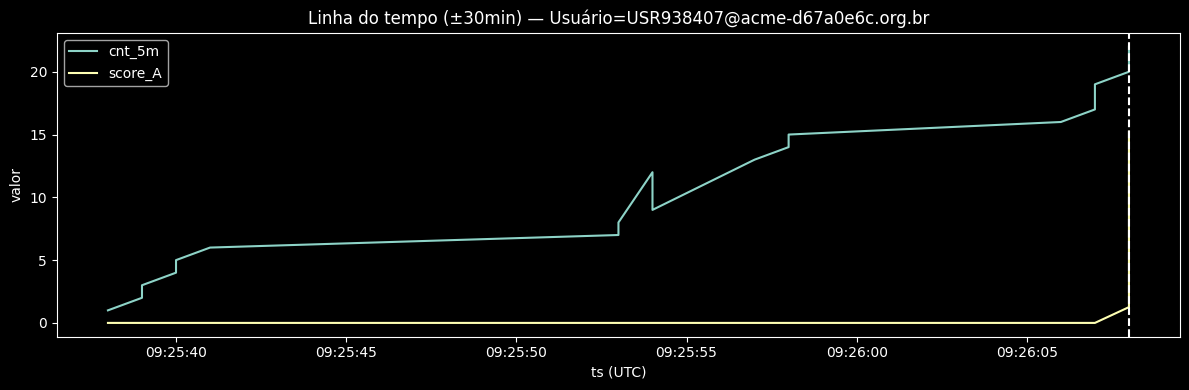

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
440803,2025-04-15 09:25:38+00:00,acme-d67a0e6c.org.br,login_success,1.0,1.0,0.0,63295.0,0.000000,
440804,2025-04-15 09:25:39+00:00,acme-d67a0e6c.org.br,login_success,2.0,2.0,0.0,1.0,0.000000,delta<=2s (automação)
440805,2025-04-15 09:25:39+00:00,acme-d67a0e6c.org.br,login_success,3.0,3.0,0.0,0.0,0.000000,delta<=2s (automação)
440806,2025-04-15 09:25:40+00:00,acme-d67a0e6c.org.br,login_success,4.0,4.0,0.0,1.0,0.000000,delta<=2s (automação)
440807,2025-04-15 09:25:40+00:00,acme-d67a0e6c.org.br,login_success,5.0,5.0,0.0,0.0,0.000000,delta<=2s (automação)
440808,2025-04-15 09:25:41+00:00,acme-d67a0e6c.org.br,login_success,6.0,6.0,0.0,1.0,0.000000,delta<=2s (automação)
440809,2025-04-15 09:25:53+00:00,acme-d67a0e6c.org.br,login_success,7.0,7.0,0.0,12.0,0.000000,
440810,2025-04-15 09:25:53+00:00,acme-d67a0e6c.org.br,login_success,8.0,8.0,0.0,0.0,0.000000,delta<=2s (automação)
440811,2025-04-15 09:25:54+00:00,acme-d67a0e6c.org.br,login_success,9.0,9.0,0.0,1.0,0.000000,delta<=2s (automação)
440812,2025-04-15 09:25:54+00:00,acme-d67a0e6c.org.br,login_success,10.0,10.0,0.0,0.0,0.000000,delta<=2s (automação)


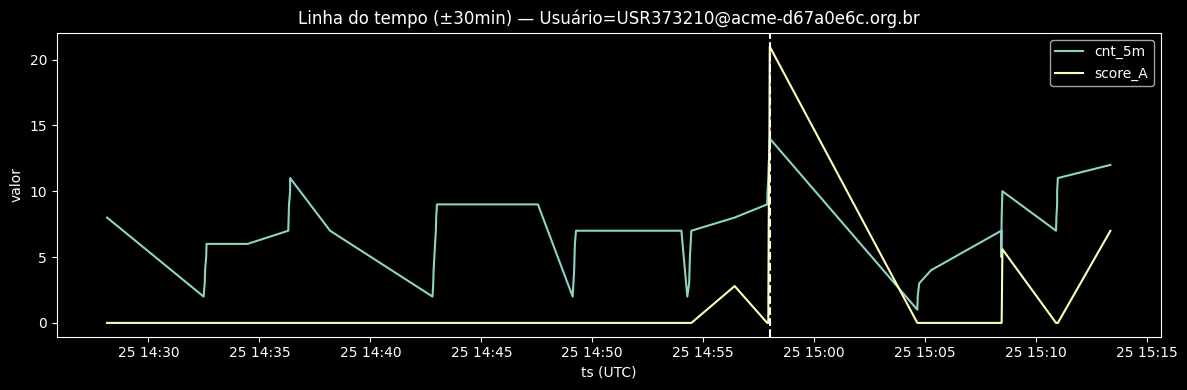

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
182337,2025-03-25 14:28:08+00:00,acme-d67a0e6c.org.br,login_success,8.0,20.0,0.0,236.0,0.000000,
182338,2025-03-25 14:32:29+00:00,acme-d67a0e6c.org.br,login_success,2.0,15.0,0.0,261.0,0.000000,
182339,2025-03-25 14:32:32+00:00,acme-d67a0e6c.org.br,login_success,3.0,16.0,0.0,3.0,0.000000,
182340,2025-03-25 14:32:33+00:00,acme-d67a0e6c.org.br,login_success,4.0,17.0,0.0,1.0,0.000000,delta<=2s (automação)
182341,2025-03-25 14:32:36+00:00,acme-d67a0e6c.org.br,login_success,5.0,18.0,0.0,3.0,0.000000,
182342,2025-03-25 14:32:37+00:00,acme-d67a0e6c.org.br,login_success,6.0,19.0,0.0,1.0,0.000000,delta<=2s (automação)
182343,2025-03-25 14:34:28+00:00,acme-d67a0e6c.org.br,login_success,6.0,15.0,0.0,111.0,0.000000,
182344,2025-03-25 14:36:18+00:00,acme-d67a0e6c.org.br,login_success,7.0,16.0,0.0,110.0,0.000000,
182345,2025-03-25 14:36:19+00:00,acme-d67a0e6c.org.br,login_success,8.0,17.0,0.0,1.0,0.000000,delta<=2s (automação)
182346,2025-03-25 14:36:20+00:00,acme-d67a0e6c.org.br,login_success,9.0,18.0,0.0,1.0,0.000000,delta<=2s (automação)


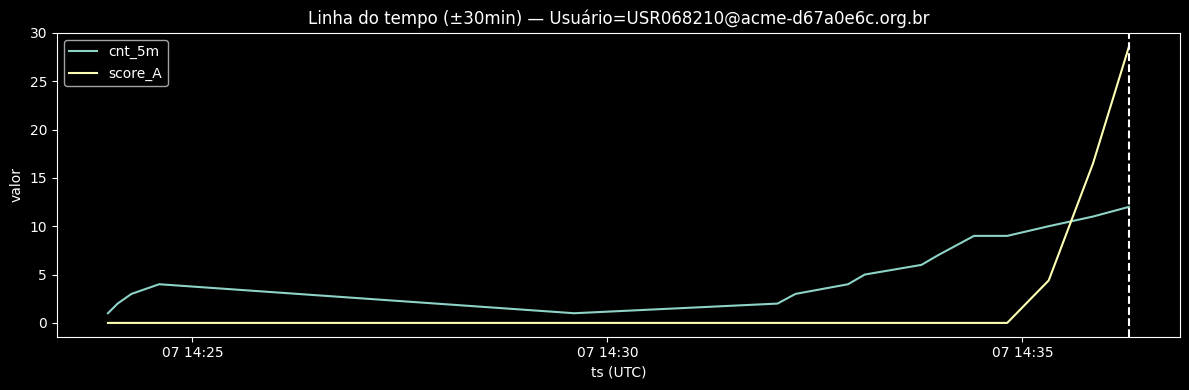

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
30816,2025-03-07 14:23:59+00:00,acme-d67a0e6c.org.br,login_success,1.0,1.0,0.0,7646.0,0.000000,
30817,2025-03-07 14:24:06+00:00,acme-d67a0e6c.org.br,login_success,2.0,2.0,0.0,7.0,0.000000,
30818,2025-03-07 14:24:16+00:00,acme-d67a0e6c.org.br,login_success,3.0,3.0,0.0,10.0,0.000000,
30819,2025-03-07 14:24:36+00:00,acme-d67a0e6c.org.br,login_success,4.0,4.0,0.0,20.0,0.000000,
30820,2025-03-07 14:29:36+00:00,acme-d67a0e6c.org.br,login_success,1.0,5.0,0.0,300.0,0.000000,
30821,2025-03-07 14:32:03+00:00,acme-d67a0e6c.org.br,login_success,2.0,6.0,0.0,147.0,0.000000,
30822,2025-03-07 14:32:16+00:00,acme-d67a0e6c.org.br,login_success,3.0,7.0,0.0,13.0,0.000000,
30823,2025-03-07 14:32:54+00:00,acme-d67a0e6c.org.br,login_success,4.0,8.0,0.0,38.0,0.000000,
30824,2025-03-07 14:33:06+00:00,acme-d67a0e6c.org.br,login_success,5.0,9.0,0.0,12.0,0.000000,
30825,2025-03-07 14:33:47+00:00,acme-d67a0e6c.org.br,login_success,6.0,10.0,0.0,41.0,0.000000,


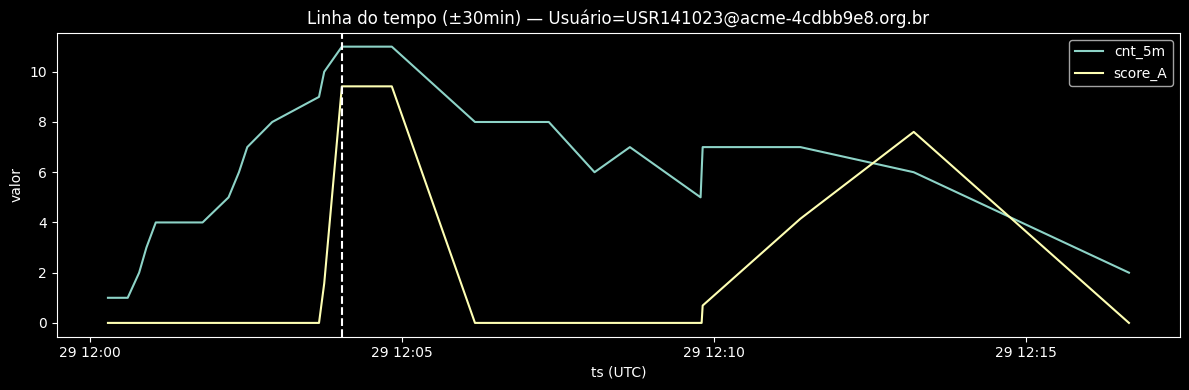

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
65241,2025-05-29 12:00:17+00:00,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.000000,57170.0,0.000000,
65242,2025-05-29 12:00:36+00:00,acme-4cdbb9e8.org.br,logout,1.0,1.0,0.000000,19.0,0.000000,
65243,2025-05-29 12:00:47+00:00,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.000000,11.0,0.000000,
65244,2025-05-29 12:00:54+00:00,acme-4cdbb9e8.org.br,login_success,3.0,3.0,0.000000,7.0,0.000000,
65245,2025-05-29 12:01:03+00:00,acme-4cdbb9e8.org.br,login_success,4.0,4.0,0.000000,9.0,0.000000,
65246,2025-05-29 12:01:24+00:00,acme-4cdbb9e8.org.br,2sv_enroll,4.0,4.0,0.000000,21.0,0.000000,
65247,2025-05-29 12:01:48+00:00,acme-4cdbb9e8.org.br,logout,4.0,4.0,0.000000,24.0,0.000000,
65248,2025-05-29 12:02:13+00:00,acme-4cdbb9e8.org.br,login_verification,5.0,5.0,0.000000,25.0,0.000000,
65249,2025-05-29 12:02:23+00:00,acme-4cdbb9e8.org.br,login_success,6.0,6.0,0.000000,10.0,0.000000,
65250,2025-05-29 12:02:31+00:00,acme-4cdbb9e8.org.br,login_success,7.0,7.0,0.000000,8.0,0.000000,


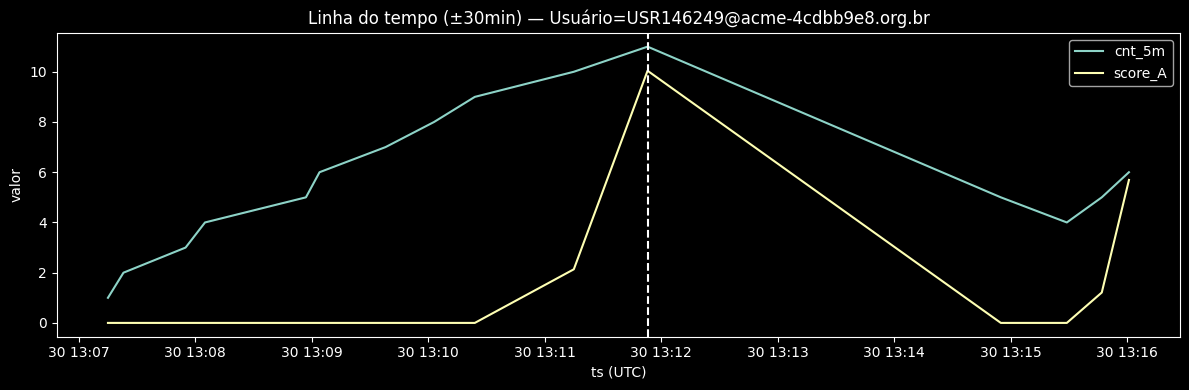

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
67564,2025-05-30 13:07:15+00:00,acme-4cdbb9e8.org.br,login_failure,1.0,1.0,1.0,85963.0,0.000000,alta falha 15m
67565,2025-05-30 13:07:23+00:00,acme-4cdbb9e8.org.br,login_failure,2.0,2.0,1.0,8.0,0.000000,alta falha 15m
67566,2025-05-30 13:07:55+00:00,acme-4cdbb9e8.org.br,login_failure,3.0,3.0,1.0,32.0,0.000000,alta falha 15m
67567,2025-05-30 13:08:05+00:00,acme-4cdbb9e8.org.br,login_failure,4.0,4.0,1.0,10.0,0.000000,alta falha 15m
67568,2025-05-30 13:08:57+00:00,acme-4cdbb9e8.org.br,login_failure,5.0,5.0,1.0,52.0,0.000000,alta falha 15m
67569,2025-05-30 13:09:04+00:00,acme-4cdbb9e8.org.br,login_failure,6.0,6.0,1.0,7.0,0.000000,alta falha 15m
67570,2025-05-30 13:09:38+00:00,acme-4cdbb9e8.org.br,login_failure,7.0,7.0,1.0,34.0,0.000000,alta falha 15m
67571,2025-05-30 13:10:03+00:00,acme-4cdbb9e8.org.br,login_failure,8.0,8.0,1.0,25.0,0.000000,alta falha 15m
67572,2025-05-30 13:10:24+00:00,acme-4cdbb9e8.org.br,login_failure,9.0,9.0,1.0,21.0,0.000000,alta falha 15m
67573,2025-05-30 13:11:15+00:00,acme-4cdbb9e8.org.br,login_failure,10.0,10.0,1.0,51.0,2.134556,"burst 5m, alta falha 15m"


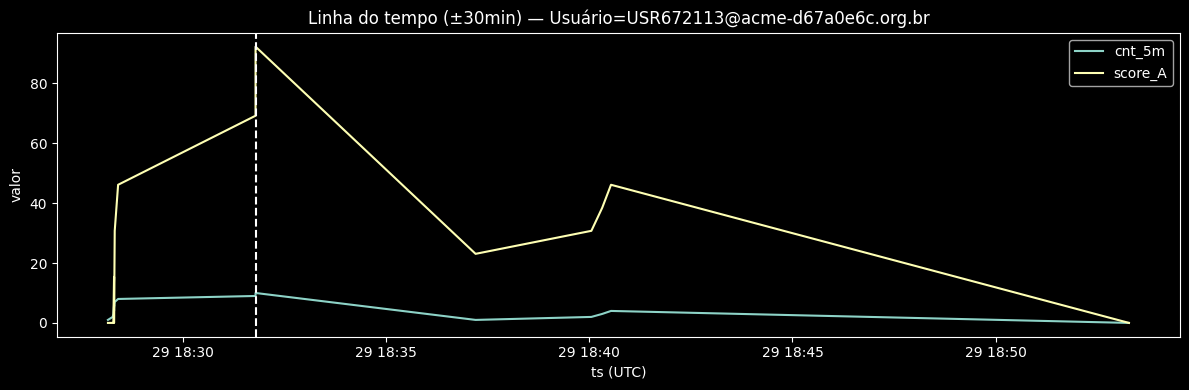

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
313913,2025-01-29 18:28:09+00:00,acme-d67a0e6c.org.br,login_success,1.0,1.0,0.0,3997.0,0.000000,
313914,2025-01-29 18:28:16+00:00,acme-d67a0e6c.org.br,login_success,2.0,2.0,0.0,7.0,0.000000,
313915,2025-01-29 18:28:17+00:00,acme-d67a0e6c.org.br,login_success,3.0,3.0,0.0,1.0,0.000000,delta<=2s (automação)
313918,2025-01-29 18:28:18+00:00,acme-d67a0e6c.org.br,login_success,6.0,6.0,0.0,0.0,15.384615,"burst 5m, delta<=2s (automação)"
313916,2025-01-29 18:28:18+00:00,acme-d67a0e6c.org.br,login_success,4.0,4.0,0.0,1.0,0.000000,delta<=2s (automação)
313917,2025-01-29 18:28:18+00:00,acme-d67a0e6c.org.br,login_success,5.0,5.0,0.0,0.0,0.000000,"burst 5m, delta<=2s (automação)"
313919,2025-01-29 18:28:19+00:00,acme-d67a0e6c.org.br,login_success,7.0,7.0,0.0,1.0,30.769231,"burst 5m, delta<=2s (automação)"
313920,2025-01-29 18:28:24+00:00,acme-d67a0e6c.org.br,login_success,8.0,8.0,0.0,5.0,46.153846,"burst 5m, burst 15m"
313921,2025-01-29 18:31:47+00:00,acme-d67a0e6c.org.br,login_success,9.0,9.0,0.0,203.0,69.230769,"burst 5m, burst 15m"
313922,2025-01-29 18:31:47+00:00,acme-d67a0e6c.org.br,login_success,10.0,10.0,0.0,0.0,92.307692,"burst 5m, burst 15m, delta<=2s (automação)"


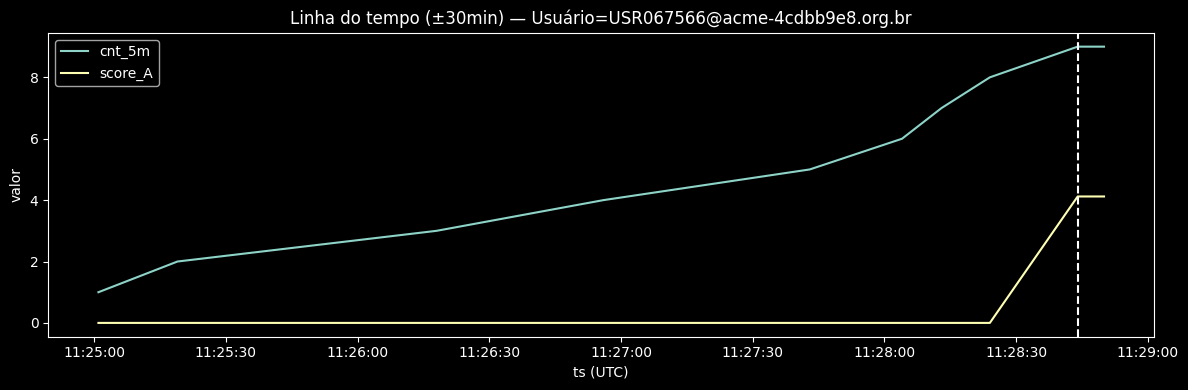

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
30518,2025-05-29 11:25:01+00:00,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,86949.0,0.000000,
30519,2025-05-29 11:25:19+00:00,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.0,18.0,0.000000,
30520,2025-05-29 11:26:18+00:00,acme-4cdbb9e8.org.br,login_success,3.0,3.0,0.0,59.0,0.000000,
30521,2025-05-29 11:26:56+00:00,acme-4cdbb9e8.org.br,login_success,4.0,4.0,0.0,38.0,0.000000,
30522,2025-05-29 11:27:43+00:00,acme-4cdbb9e8.org.br,login_success,5.0,5.0,0.0,47.0,0.000000,
30523,2025-05-29 11:28:04+00:00,acme-4cdbb9e8.org.br,login_success,6.0,6.0,0.0,21.0,0.000000,
30524,2025-05-29 11:28:13+00:00,acme-4cdbb9e8.org.br,login_success,7.0,7.0,0.0,9.0,0.000000,
30525,2025-05-29 11:28:24+00:00,acme-4cdbb9e8.org.br,login_success,8.0,8.0,0.0,11.0,0.000000,
30526,2025-05-29 11:28:44+00:00,acme-4cdbb9e8.org.br,login_success,9.0,9.0,0.0,20.0,4.118993,"burst 5m, burst 15m"
30527,2025-05-29 11:28:50+00:00,acme-4cdbb9e8.org.br,2sv_enroll,9.0,9.0,0.0,6.0,4.118993,"burst 5m, burst 15m"


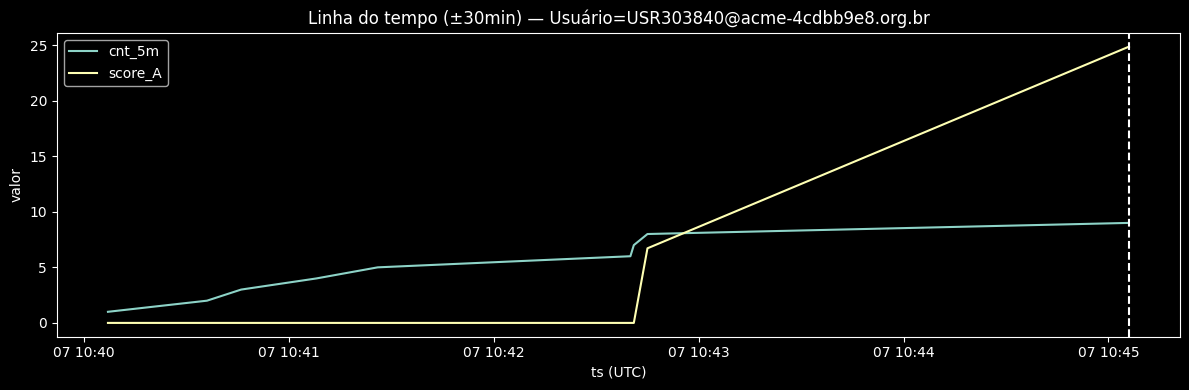

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
148396,2025-04-07 10:40:07+00:00,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,1752.0,0.000000,
148397,2025-04-07 10:40:36+00:00,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.0,29.0,0.000000,
148398,2025-04-07 10:40:46+00:00,acme-4cdbb9e8.org.br,login_success,3.0,3.0,0.0,10.0,0.000000,
148399,2025-04-07 10:41:08+00:00,acme-4cdbb9e8.org.br,login_success,4.0,4.0,0.0,22.0,0.000000,
148400,2025-04-07 10:41:26+00:00,acme-4cdbb9e8.org.br,login_success,5.0,5.0,0.0,18.0,0.000000,
148401,2025-04-07 10:42:40+00:00,acme-4cdbb9e8.org.br,login_success,6.0,6.0,0.0,74.0,0.000000,
148402,2025-04-07 10:42:41+00:00,acme-4cdbb9e8.org.br,login_success,7.0,7.0,0.0,1.0,0.000000,delta<=2s (automação)
148403,2025-04-07 10:42:45+00:00,acme-4cdbb9e8.org.br,login_success,8.0,8.0,0.0,4.0,6.714387,"burst 5m, burst 15m"
148404,2025-04-07 10:45:06+00:00,acme-4cdbb9e8.org.br,login_success,9.0,9.0,0.0,141.0,24.861377,"burst 5m, burst 15m"


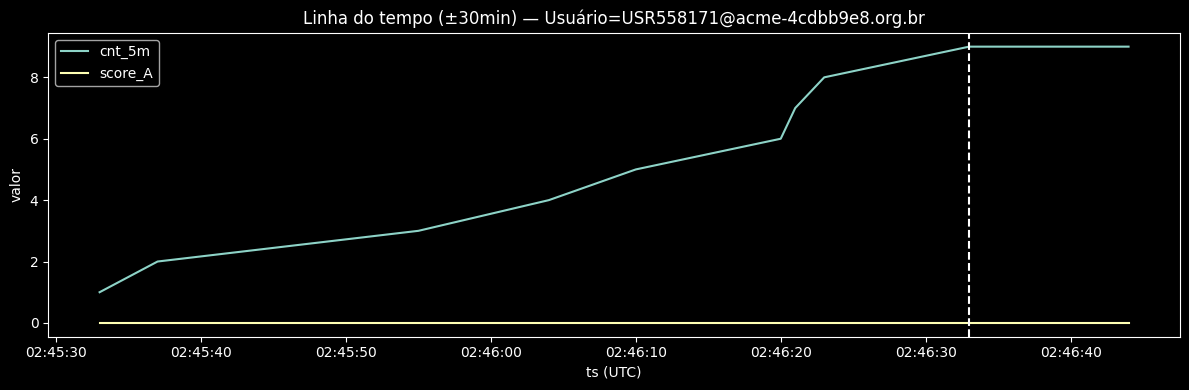

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
268228,2025-01-01 02:45:33+00:00,acme-4cdbb9e8.org.br,login_success,1.0,1.0,0.0,NaN,0.0,
268229,2025-01-01 02:45:37+00:00,acme-4cdbb9e8.org.br,login_success,2.0,2.0,0.0,4.0,0.0,
268230,2025-01-01 02:45:55+00:00,acme-4cdbb9e8.org.br,login_success,3.0,3.0,0.0,18.0,0.0,
268231,2025-01-01 02:46:04+00:00,acme-4cdbb9e8.org.br,login_success,4.0,4.0,0.0,9.0,0.0,
268232,2025-01-01 02:46:10+00:00,acme-4cdbb9e8.org.br,login_success,5.0,5.0,0.0,6.0,0.0,
268233,2025-01-01 02:46:20+00:00,acme-4cdbb9e8.org.br,login_success,6.0,6.0,0.0,10.0,0.0,
268234,2025-01-01 02:46:21+00:00,acme-4cdbb9e8.org.br,login_success,7.0,7.0,0.0,1.0,0.0,delta<=2s (automação)
268235,2025-01-01 02:46:23+00:00,acme-4cdbb9e8.org.br,login_success,8.0,8.0,0.0,2.0,0.0,delta<=2s (automação)
268236,2025-01-01 02:46:33+00:00,acme-4cdbb9e8.org.br,login_success,9.0,9.0,0.0,10.0,0.0,"burst 5m, burst 15m"
268237,2025-01-01 02:46:44+00:00,acme-4cdbb9e8.org.br,logout,9.0,9.0,0.0,11.0,0.0,"burst 5m, burst 15m"


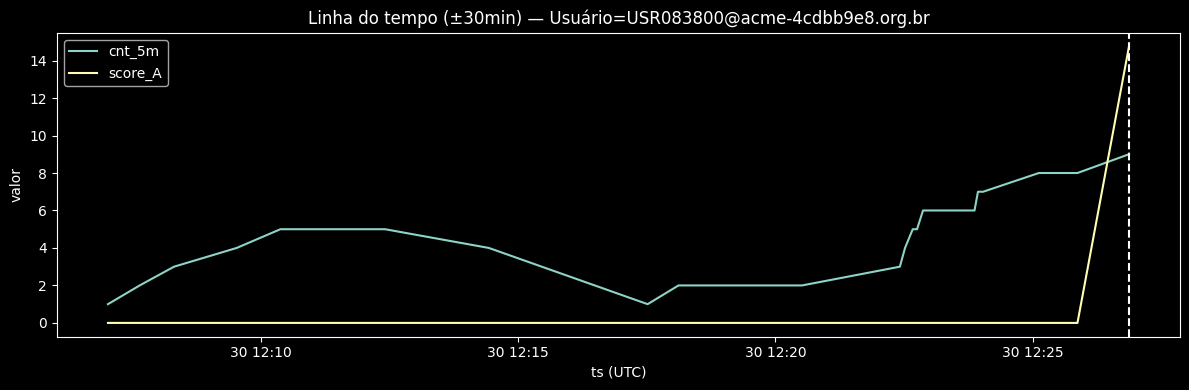

,ts,Domínio,Evento,cnt_5m,cnt_15m,fail_ratio_15m,delta_prev_s,score_A,reasons_A
37396,2025-05-30 12:07:02+00:00,acme-4cdbb9e8.org.br,login_failure,1.0,3.0,1.000000,786.0,0.00000,alta falha 15m
37397,2025-05-30 12:07:39+00:00,acme-4cdbb9e8.org.br,login_failure,2.0,4.0,1.000000,37.0,0.00000,alta falha 15m
37398,2025-05-30 12:08:19+00:00,acme-4cdbb9e8.org.br,login_failure,3.0,5.0,1.000000,40.0,0.00000,alta falha 15m
37399,2025-05-30 12:09:32+00:00,acme-4cdbb9e8.org.br,login_success,4.0,4.0,0.750000,73.0,0.00000,
37400,2025-05-30 12:10:23+00:00,acme-4cdbb9e8.org.br,login_success,5.0,5.0,0.600000,51.0,0.00000,
37401,2025-05-30 12:12:25+00:00,acme-4cdbb9e8.org.br,login_success,5.0,6.0,0.500000,122.0,0.00000,
37402,2025-05-30 12:14:26+00:00,acme-4cdbb9e8.org.br,login_success,4.0,7.0,0.428571,121.0,0.00000,
37403,2025-05-30 12:17:31+00:00,acme-4cdbb9e8.org.br,logout,1.0,7.0,0.428571,185.0,0.00000,
37404,2025-05-30 12:18:07+00:00,acme-4cdbb9e8.org.br,login_verification,2.0,8.0,0.375000,36.0,0.00000,
37405,2025-05-30 12:20:23+00:00,acme-4cdbb9e8.org.br,login_success,2.0,9.0,0.333333,136.0,0.00000,


In [ ]:
def plot_timeline_for_user(user_id: str, window_minutes=30):
    g = scored[scored['Usuário'] == user_id].copy()
    if g.empty:
        return None
    g = g.sort_values('ts')

    idx = g['cnt_5m'].idxmax()
    t0 = g.loc[idx, 'ts']
    tmin = t0 - pd.Timedelta(minutes=window_minutes)
    tmax = t0 + pd.Timedelta(minutes=window_minutes)
    w = g[(g['ts'] >= tmin) & (g['ts'] <= tmax)].copy()

    plt.figure(figsize=(12,4))
    plt.plot(w['ts'], w['cnt_5m'], label='cnt_5m')
    plt.plot(w['ts'], w['score_A'], label='score_A')
    plt.axvline(t0, linestyle='--')
    plt.title(f'Linha do tempo (±{window_minutes}min) — Usuário={user_id}')
    plt.xlabel('ts (UTC)')
    plt.ylabel('valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

    cols = ['ts','Domínio','Evento','cnt_5m','cnt_15m','fail_ratio_15m','delta_prev_s','score_A','reasons_A']
    return w[cols].sort_values('ts')

for u in top_users:
    tbl = plot_timeline_for_user(u, window_minutes=30)
    if tbl is not None:
        display(tbl.head(40))